In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import time

In [2]:
print('torch.cuda.is_available:\t',torch.cuda.is_available())
print('torch.cuda.device_count:\t',torch.cuda.device_count())
print('torch.cuda.current_device:\t',torch.cuda.current_device())
print('torch.cuda.device:\t\t',torch.cuda.device(0))
print('torch.cuda.get_device_name:\t',torch.cuda.get_device_name(0))
print()

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    else:
        print('Running on {}'.format(device))
    return device

device = set_device("gpu")

torch.cuda.is_available:	 True
torch.cuda.device_count:	 1
torch.cuda.current_device:	 0
torch.cuda.device:		 <torch.cuda.device object at 0x7fa8a46f5e10>
torch.cuda.get_device_name:	 Quadro RTX 4000

Cuda installed! Running on GPU 0 Quadro RTX 4000!


In [3]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x0, tolerance=1e-6, max_iterations=10000):
    """
    Solves a linear system of equations using the Gauss-Seidel method.
    
    Parameters
    ----------
    A (numpy.ndarray): Coefficient matrix.
    b (numpy.ndarray): Right-hand side vector.
    x0 (numpy.ndarray): Initial guess for the solution vector.
    tol (float): Tolerance for convergence.
    max_iter (int): Maximum number of iterations.
    
    Returns
    ----------
    x (numpy.ndarray): Solution vector.
    """
    x = x0.clone().detach()
    x_old = x0.clone().detach()
    for k in range(max_iterations):
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - torch.matmul(A[i,:i], x[:i]) - torch.matmul(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        error = torch.max(torch.abs(x - x_old))
        if  error < tolerance:
            print(f'The L infinity norm in iteration {k+1} is: {error}') 
            break     
        x_old[:] = x 
    else:
        print(f'***WARNING*** Max number of iteration reached {k+1}, L infinity norm is: {error}')        
    return x

def jacobi(A, b, x0, tolerance=1e-6, max_iterations=50000):
    """
    Solves a linear system of equations using the Jacobi method.
    
    Parameters:
    A (numpy.ndarray): Coefficient matrix.
    b (numpy.ndarray): Right-hand side vector.
    x0 (numpy.ndarray): Initial guess for the solution vector.
    tolerance (float): Tolerance for convergence.
    max_iterations (int): Maximum number of iterations.
    
    Returns:
    x (numpy.ndarray): Solution vector.
    """    
    x_old = x0.clone().detach()
    x = torch.empty_like(x0)
    diagonal = A.diag()
    B = A - torch.diag(diagonal)     
    for k in range(max_iterations): 
        x[:] = (b - torch.matmul(B, x_old)) / diagonal   
        #Stop condition 
        error = torch.max(torch.abs(x - x_old))
        if  error < tolerance:   
            print(f'The L infinity norm in iteration {k+1} is: {error}') 
            break      
        x_old[:] = x
    else:
        print(f'***WARNING*** Max number of iteration reached {k+1}, L infinity norm is: {error}')        
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        return torch.linalg.solve(A, b)
        #return jacobi(A, b, -b)
        #return gauss_seidel(A, b, -b)
        #return torch.linalg.pinv(A).matmul(b) 

### Diffusion/Heat Equation

$
\frac{\displaystyle \partial u}{\displaystyle \partial t} = \alpha\nabla^2 u + f 
$

#### Von Neumann stability condition (for explicit)

$
r = \frac{\displaystyle \alpha \Delta t}{\displaystyle (\Delta x)^2} \\
r \le \frac{\displaystyle 1}{\displaystyle 2}
$



In [4]:
# (solve Au=f for each time step) 

class Heat(nn.Module): 
    """
    Finite difference solution of the Heat/Diffusion equation (parabolic equation)

    Parameters
    ----------
    alpha: float
        Diffusivity in m*m/s
    dx: float
        Block size in meters
    N: int
        Number of blocks
    initial_condition: list (or numpy array) of floats
        Initial condition (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet' or 'Neumann'), e.g. ['Dirichlet','Neumann']    
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    time_integration: str | default 'implicit'
        Time integration (options: explict, implicit or Crank-Nicolson), e.g. 'implicit'
    
    Methods
    -------
    forward(dt, source_term=None)
        Solve the heat equation for one time step of size dt considering the source term

    """      
    def __init__(self, alpha, dx, N, initial_condition, boundary_type = ['Dirichlet','Dirichlet'], boundary_values=[0, 0], time_integration='implicit'):
        super().__init__()
        self.N = N # torch.tensor(N, dtype=torch.int32, device=device) -> give error compiled version  
        self.alpha = torch.tensor(alpha, dtype=torch.float32, device=device) 
        self.dx = torch.tensor(dx, dtype=torch.float32, device=device)  
        self.u_previous = torch.tensor(initial_condition, dtype=torch.float32, device=device)  # For the first time step
        self.boundary_type = boundary_type
        self.boundary_values = torch.tensor(boundary_values, dtype=torch.float32, device=device) 
        self.time_integration = time_integration 
        self.A = None
        self.f = None
        #self.timestep_count = torch.tensor(0, dtype=torch.int32, device=device)  # gives warning compiled version
        #self.total_time = torch.tensor(0., dtype=torch.float32, device=device)   # gives warning compiled version

    
    # Solve the PDE discretized equation explicitly  
    def solve_explicit(self, dt, source_term):
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
       
        # initialize u and add source term
        u = self.u_previous + dt*source_term
        
        # Calculate diffusion term for elements not in the boundary
        for i in range(1,self.N-1):
            u[i] += r*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])     
        
        # Calculate diffusion term for elements in the boundaries 
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            u[0] += r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])           
        elif self.boundary_type[0] == 'Neumann':
            u[0] += r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1])    
        else:
            raise RuntimeError('Left boundary: no condition satisfaed!')   
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            u[-1] += r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1])  
        elif self.boundary_type[1] == 'Neumann':
            u[-1] += r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])   
        else:
            raise RuntimeError('Right boundary: no condition satisfaed!')      
        
        return u

    # Solve the PDE discretized equation fully implicit  
    def solve_implicit(self, dt, source_term):
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        # (Au=f) Calculate matrix A and f 
        ## matrix A
        a_main = (1+2*r)*torch.ones((self.N,), dtype=torch.float32, device=device) # Main diagonal values
        a_upper = -r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Upper diagonal values
        a_lower = -r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Lower diagonal values
        self.A  = torch.diag(a_main, 0)      # Main diagonal
        self.A += torch.diag(a_upper, 1)     # Upper diagonal
        self.A += torch.diag(a_lower,-1)     # Lower diagonal      
        ## Source term plus constants f
        self.f = self.u_previous + dt*source_term      
        
        # Calculate boundary conditions 
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            self.f[0] += self.boundary_values[0]*r  
        elif self.boundary_type[0] == 'Neumann':
            self.f[0]  += -self.boundary_values[0]*r*self.dx   
            self.A[0,0] += -r
        else:
            raise RuntimeError('Left boundary: no condition satisfaed!')
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            self.f[-1] += self.boundary_values[-1]*r
        elif self.boundary_type[1] == 'Neumann':
            self.f[-1] += self.boundary_values[-1]*r*self.dx  
            self.A[-1,-1] += -r
        else:
            raise RuntimeError('Right boundary: no condition satisfaed!')
         
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u
    
    # Solve the PDE discretized equation using Crank-Nicolson (theta = 0 -> explicit, 1-> implicit)
    def solve_CrankNicolson(self, dt, source_term, theta=0.5):
        
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        a_main = theta*(1+2*r)*torch.ones((self.N,), dtype=torch.float32, device=device) # Main diagonal values
        a_upper = -theta*r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Upper diagonal values
        a_lower = -theta*r*torch.ones((self.N-1,), dtype=torch.float32, device=device)   # Lower diagonal values
        self.A  = torch.diag(a_main, 0)   # Main diagonal
        self.A += torch.diag(a_upper, 1)     # Upper diagonal
        self.A += torch.diag(a_lower,-1)     # Lower diagonal           
        #
        ## Source term plus constants f
        self.f = self.u_previous + dt*source_term
        for i in range(1,self.N-1):
            self.f[i] += r*(1-theta)*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])
                                            
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            self.f[0] += (1-theta)*r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])
            self.f[0] += theta*r*self.boundary_values[0]
        elif self.boundary_type[0] == 'Neumann':
            self.f[0] += (1-theta)*r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1])
            self.f[0] += -theta*self.dx*r*self.boundary_values[0]
            self.A[0,0] += -theta*r
        else:
            raise RuntimeError('Left boundary: no condition satisfaed!')
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1])
            self.f[-1] += theta*r*self.boundary_values[-1]
        elif self.boundary_type[1] == 'Neumann':
            self.f[-1] += (1-theta)*r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])
            self.f[-1] += theta*self.dx*r*self.boundary_values[-1] 
            self.A[-1,-1] += -theta*r
        else:
            raise RuntimeError('Right boundary: no condition satisfaed!')
         
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u 
    
            
    def forward(self, dt, source_term=None):
        """
        Solve the heat equation for one time step of size dt considering the source term
        
        
        Parameters
        ----------
        dt: float
            Time step size in seconds
        source_term: list (or numpy array) of floats | default None
            Source term (one value per block -> size N)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field after time step dt (one value per block -> size N)

        """  
        source_term = torch.zeros((self.N,), dtype=torch.float32, device=device) if source_term == None else torch.tensor(source_term, dtype=torch.float32, device=device)
        
        if self.time_integration == 'implicit':
            #self.timestep_count += 1
            #self.total_time += dt
            #print(f'Time step {self.timestep_count} => dt = {dt}s, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.total_time}s')

            u = self.solve_implicit(dt, source_term)
            self.u_previous = u
            
        elif self.time_integration == 'Crank-Nicolson':
            #self.timestep_count += 1
            #self.total_time += dt
            #print(f'Time step {self.timestep_count} => dt = {dt}s, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.total_time}s')
          
            u = self.solve_CrankNicolson(dt, source_term, theta=0.5)
            self.u_previous = u            
    
        elif self.time_integration == 'explicit':
            #self.timestep_count += 1
            #self.total_time += dt
            #print(f'Time step {self.timestep_count} => dt = {dt}s, r = {self.alpha*dt/(self.dx*self.dx):.2f}{"(***WARNING r>=1/2)" if self.alpha*dt/(self.dx*self.dx) >= 0.5 else ""}, total time = {self.total_time}s')
           
            u = self.solve_explicit(dt, source_term)
            self.u_previous = u
            
        else:
            raise RuntimeError(f'Time integration {self.time_integration} NOT available!')
        
        return u

### Solve implicit

In [5]:
heat = Heat(alpha = 0.001, # Thermal diffusivity of Aluminium (0.0001)
            dx=0.01,
            N=10000, 
            initial_condition =  2000*[100.]+3000*[100.]+5000*[0.],
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            boundary_values = [0, 0],
            time_integration='implicit').to(device)

In [6]:
# Initialize u
u=[]
u.append(heat.u_previous.clone().detach().cpu().numpy())  # Initial condition

In [7]:
start = time.time()
with torch.no_grad():
    for _ in range(1):
        heat(dt=30.0)
    #u.append(heat(dt=30.0, # seconds
    #                      #source_term=1*[0.]+9*[0.]+1*[0.]
    #                      ).cpu().numpy()
    #        )
time1 = time.time()-start 
print(time1)

0.888432502746582


20.176357984542847
21.06479048728943


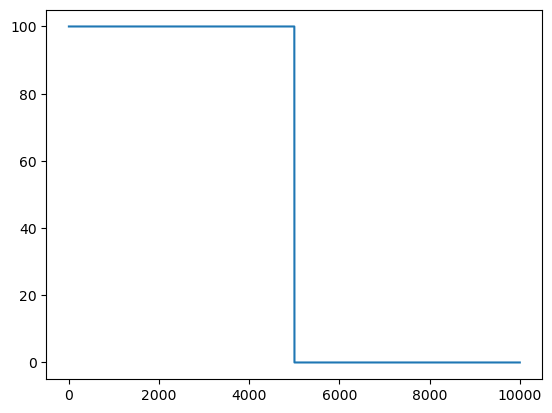

In [8]:
start = time.time()
with torch.no_grad():
    for _ in range(100):
        heat(dt=30.0)
    #u.append(heat(dt=30.0, # seconds
    #                      #source_term=1*[0.]+9*[0.]+1*[0.]
    #                      ).cpu().numpy()
    #        )
time2 = time.time()-start 
print(time2)
print(time1+time2)
plt.plot(np.transpose(u));
u_imp = u

A = 
 tensor([[ 301.0000, -300.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [-300.0000,  601.0001, -300.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000, -300.0000,  601.0001,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ...,  601.0001, -300.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ..., -300.0000,  601.0001,
         -300.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000, -300.0000,
          301.0000]], device='cuda:0')

u = 
 [100. 100. 100. ...   0.   0.   0.]

f = 
 tensor([1.0004e+02, 1.0004e+02, 1.0004e+02,  ..., 1.9974e-41, 1.9974e-41,
        1.9974e-41], device='cuda:0')



/home/viluiz/anaconda3/envs/numpde/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Determinant = inf
Error =  30049.97


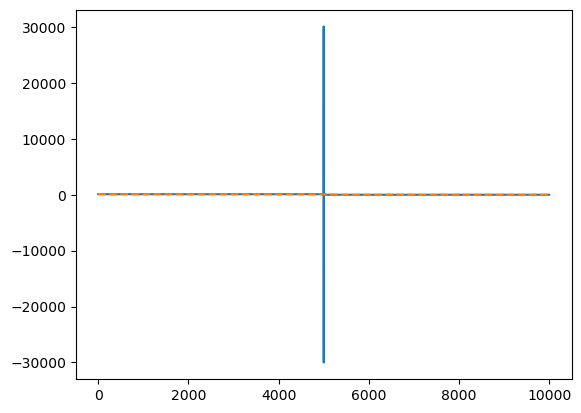

In [9]:
print('A = \n', heat.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', heat.f)
print()
print('Determinant =', np.linalg.det(heat.A.cpu()))
print('Error = ', np.max(abs(np.dot(heat.A.cpu(),u[-1])-heat.f.cpu().numpy())))

plt.plot(np.dot(heat.A.cpu(),u[-1]))
plt.plot(heat.f.cpu().numpy(), '--')

[100. 100. 100. ...   0.   0.   0.]


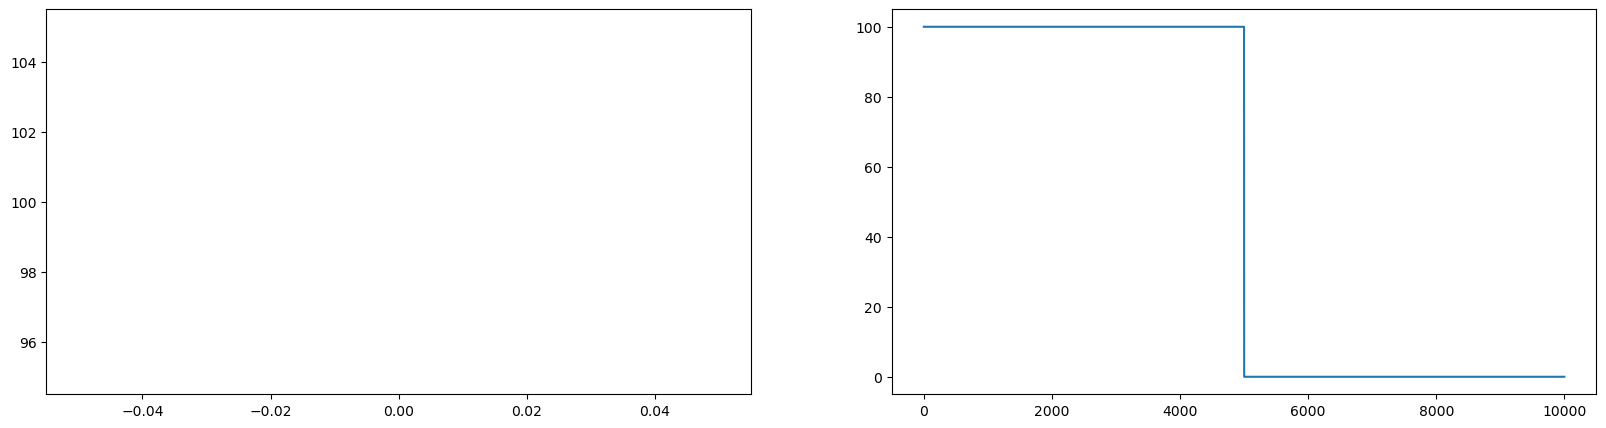

In [10]:
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_imp)[:,5])
axes[1].plot(u_imp[-1])

### Solve explicit

### Solve Crank-Nicolson